In [1]:
import torch
import torchvision
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# parameter and dataset initialization
BATCH_SIZE = 32
EPOCH_NUM = 80
learning_rate = 1e-4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()

transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize(mean=(0.5,), std=(0.5,))])

trainset = datasets.MNIST(root='./data', train=True,
                          download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=4)

testset = datasets.MNIST(root='./data', train=False,
                         download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=True, num_workers=4)

In [3]:
class ShallowNN(nn.Module):
    def __init__(self, k, p):
        super(ShallowNN, self).__init__()
        # pytorch linear layer initialize weights with kaiming_uniform_
        self.fc1 = nn.Linear(784, k, bias=False)
        self.fc2 = nn.Linear(k, 10, bias=False)
        self.dropout = nn.Dropout(p)
    
    def forward(self, x):
        # Flaten the image and build neural network with two linear layers
        output = torch.flatten(x, start_dim=1)
        output = self.fc1(output)
        output = F.relu(output)
        output = self.fc2(output)
        # Put the dropout layer after the output layer
        output = self.dropout(output)
        output = F.softmax(output)
        return output

In [4]:
def train(model, trainloader):
    # train_accuracy = []
    # train_loss = []
    model.train()
    # running_loss = 0.0
    # test_min_acc = 0
    total = 0
    correct = 0

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs.to(device))
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()

        # running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted.cpu() == labels).sum().item()

        # train_loss.append(running_loss)
        train_accuracy = 100.0*correct/total

    return train_accuracy, loss.item()


def test(model, testloader):
    # test_accuracy = []
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            model.eval()
            outputs = model(inputs.to(device))
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted.cpu() == labels).sum().item()
            test_ep_acc = 100.0*correct/total
            # test_accuracy.append(100.0*correct/total)
    # test_ep_acc = test_accuracy[-1]
    # print('Test Accuracy: %.3f %%' % (test_ep_acc))
    return test_ep_acc

In [5]:
k_grid = [1, 3, 5, 10, 15, 20, 30, 40]
p_grid = [0.9, 0.5, 0]

# Train model and evaluation with different k and p
test_accuracy = np.zeros((3,8))
train_accuracy = np.zeros((3,8))
loss = np.zeros((3,8))
for p_num, p in enumerate(p_grid):
    for k_num, k in enumerate(k_grid):
        model = ShallowNN(k, p)
        model.to(device)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        for epoch in range(EPOCH_NUM):
            train_ep_acc, loss_ep = train(model, trainloader)
        train_accuracy[p_num, k_num] = train_ep_acc
        loss[p_num, k_num] = loss_ep
        test_accuracy[p_num, k_num] = test(model, testloader)

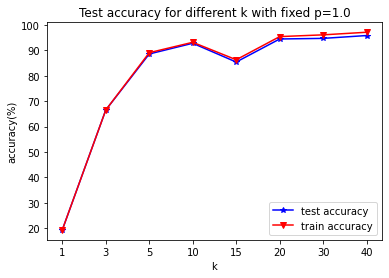

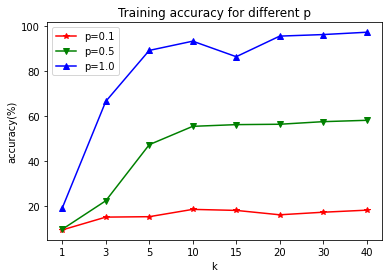

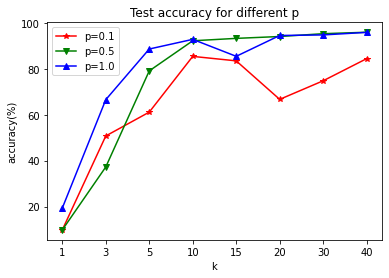

In [6]:
# Fix p=1.0 and plot training and test accuracy
plt.figure()
plt.plot(test_accuracy[2,:], 'b', marker='*', label="test accuracy")
plt.plot(train_accuracy[2,:], 'r', marker='v', label="train accuracy")
plt.title('Test accuracy for different k with fixed p=1.0')
plt.ylabel('accuracy(%)')
plt.xlabel('k')
plt.xticks(range(8),k_grid)
plt.legend()

# Training accuracy with different p on same plot
plt.figure()
plt.plot(train_accuracy[0,:], 'r', marker='*', label="p=0.1")
plt.plot(train_accuracy[1,:], 'g', marker='v', label="p=0.5")
plt.plot(train_accuracy[2,:], 'b', marker='^', label="p=1.0")
plt.title('Training accuracy for different p')
plt.ylabel('accuracy(%)')
plt.xlabel('k')
plt.xticks(range(8),k_grid)
plt.legend()

# test accuracy with different p on same plot
plt.figure()
plt.plot(test_accuracy[0,:], 'r', marker='*', label="p=0.1")
plt.plot(test_accuracy[1,:], 'g', marker='v', label="p=0.5")
plt.plot(test_accuracy[2,:], 'b', marker='^', label="p=1.0")
plt.title('Test accuracy for different p')
plt.ylabel('accuracy(%)')
plt.xlabel('k')
plt.xticks(range(8),k_grid)
plt.legend()
plt.show()

In [7]:
# add noise to label
noise_trainset = []

# Choose 24,000 (40% of training set)
noise_idx = np.random.choice(60000, size=24000, replace=False)

# Make chosen labels noised
for idx in range(len(trainset)):
    image, label = trainset[idx]
    noise_label = label
    if np.isin(noise_idx, idx).any():
        while(noise_label == label):
            noise_label = np.random.randint(10)
    noise_trainset.append((image, noise_label))

trainloader = torch.utils.data.DataLoader(noise_trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

In [8]:
# run with noised training data
test_accuracy = np.zeros((3,8))
train_accuracy = np.zeros((3,8))
loss = np.zeros((3,8))
for p_num, p in enumerate(p_grid):
    for k_num, k in enumerate(k_grid):
        model = ShallowNN(k, p)
        model.to(device)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        for epoch in range(EPOCH_NUM):
            train_ep_acc, loss_ep = train(model, trainloader)
        train_accuracy[p_num, k_num] = train_ep_acc
        loss[p_num, k_num] = loss_ep
        test_accuracy[p_num, k_num] = test(model, testloader)

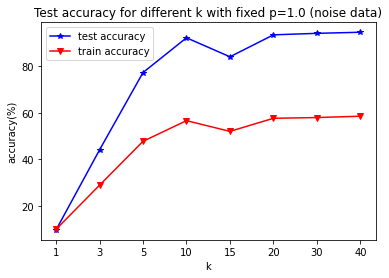

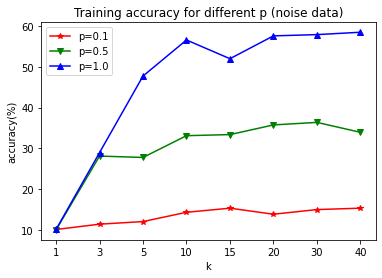

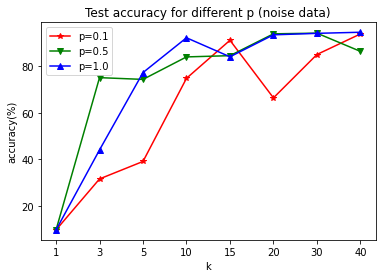

In [9]:
# Fix p=1.0 and plot training and test accuracy
plt.figure()
plt.plot(test_accuracy[2,:], 'b', marker='*', label="test accuracy")
plt.plot(train_accuracy[2,:], 'r', marker='v', label="train accuracy")
plt.title('Test accuracy for different k with fixed p=1.0 (noise data)')
plt.ylabel('accuracy(%)')
plt.xlabel('k')
plt.xticks(range(8),k_grid)
plt.legend()

# Training accuracy with different p on same plot
plt.figure()
plt.plot(train_accuracy[0,:], 'r', marker='*', label="p=0.1")
plt.plot(train_accuracy[1,:], 'g', marker='v', label="p=0.5")
plt.plot(train_accuracy[2,:], 'b', marker='^', label="p=1.0")
plt.title('Training accuracy for different p (noise data)')
plt.ylabel('accuracy(%)')
plt.xlabel('k')
plt.xticks(range(8),k_grid)
plt.legend()

# test accuracy with different p on same plot
plt.figure()
plt.plot(test_accuracy[0,:], 'r', marker='*', label="p=0.1")
plt.plot(test_accuracy[1,:], 'g', marker='v', label="p=0.5")
plt.plot(test_accuracy[2,:], 'b', marker='^', label="p=1.0")
plt.title('Test accuracy for different p (noise data)')
plt.ylabel('accuracy(%)')
plt.xlabel('k')
plt.xticks(range(8),k_grid)
plt.legend()
plt.show()